# HW8: Multi-Class Classification
## 2022104346 정지헌

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Literal, Iterable
from torch import nn

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

모델 정의

In [2]:
class SeqModel(nn.Module):
    def __init__(self, depth: int, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 6):
        super().__init__()
        self.layer_list = nn.ModuleList()
        self.layer_list.append(nn.Linear(input_dim, hidden_dim))
        self.layer_list.append(nn.Tanh())

        for _ in range(depth - 1):
            self.layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            self.layer_list.append(nn.Tanh())

        self.layer_list.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x: torch.Tensor):
        for layer in self.layer_list:
            x = layer(x)
        
        return x

데이터 생성기

In [3]:
class ThreeClassDataLoader:
    def __init__(self, validation_ratio: float, device: Literal["cpu", "cuda"]):
        raw_data = np.loadtxt("./3_layercake_data.csv", delimiter = ",", dtype = np.float32)
        raw_data = np.transpose(raw_data)
        np.random.shuffle(raw_data)
        self.input_coordinates = raw_data[:, :2] # (110, 2)
        self.output_classes = raw_data[:, 2] # (110,)
        self.data_count = raw_data.shape[0]
        self.validation_data_count = int(self.data_count * validation_ratio)
        
        self.validation_input = torch.tensor(self.input_coordinates[:self.validation_data_count, :], dtype = torch.float32, device = device)
        self.validation_output = torch.tensor(self.output_classes[:self.validation_data_count], dtype = torch.int64, device = device)
        self.training_input = torch.tensor(self.input_coordinates[self.validation_data_count:, :], dtype = torch.float32, device = device)
        self.training_output = torch.tensor(self.output_classes[self.validation_data_count:], dtype = torch.int64, device = device)
        
    def load_training_data(self):
        return self.training_input, self.training_output
    
    def load_validation_data(self):
        return self.validation_input, self.validation_output
    
    def return_full_data(self):
        return self.input_coordinates, self.output_classes

모델을 생성하고 학습시키는 클래스

In [4]:
class Trainer:
    def __init__(self, learning_rate: float, epoch: int, device: Literal["cpu", "cuda"], 
                 model_depth: int, model_hidden_dim: int, model_input_dim: int, class_count: int, validation_ratio):

        self.learning_rate = learning_rate
        self.epoch = epoch
        self.class_count = class_count
        self.model_input_dim = model_input_dim
        self.device = device

        self.min_validation_loss = 1e30 # saves the minimum validation loss ever 
        self.min_validation_loss_model = None # saves the state dict of the model that gave the minimum validation loss

        self.model = SeqModel(depth = model_depth, input_dim = model_input_dim, output_dim = class_count, hidden_dim = model_hidden_dim).to(device)
        self.data_loader = ThreeClassDataLoader(validation_ratio = validation_ratio, device = device)
        self.final_layer = nn.LogSoftmax(dim = 1).to(device)
        self.loss_fn = nn.NLLLoss().to(device)
        self.optimizer = torch.optim.Adam(params = self.model.parameters(), lr = learning_rate) # logsoftmax and nllloss modules have no parameters
        

    def _train(self):
        training_input, training_output = self.data_loader.load_training_data()

        model_output = self.model.forward(training_input) # (99, 3)
        model_output = self.final_layer.forward(model_output) # (99, 3)
        loss = self.loss_fn.forward(model_output, training_output) # (99, 3) and (99,) as input, scalar as output

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return float(loss)
    
    def _validate(self):
        with torch.no_grad():
            validation_input, validation_output = self.data_loader.load_validation_data()
            model_output = self.model.forward(validation_input)
            model_output = self.final_layer.forward(model_output)
            loss = self.loss_fn.forward(model_output, validation_output)

            return float(loss)
        
    def run_loop(self):
        for _ in range(self.epoch):
            training_loss = self._train()
            validation_loss = self._validate()

            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.min_validation_loss_model = self.model.state_dict()

        self.model.load_state_dict(self.min_validation_loss_model)
        
    def inference_random_sample(self, n: int):
        with torch.no_grad():
            input_coordinates = torch.rand((n, self.model_input_dim), device = self.device)

            model_output = self.model.forward(input_coordinates) 
            model_output = self.final_layer.forward(model_output)
            labels = torch.argmax(model_output, dim = 1).numpy(force = True)

            return input_coordinates.numpy(force = True), labels

학습 루프

In [5]:
trainer = Trainer(learning_rate = 1e-3,
                  epoch = 100000, 
                  device = DEVICE,
                  model_depth = 3,
                  model_hidden_dim = 16,
                  model_input_dim = 2,
                  class_count = 3,
                  validation_ratio = 0.2)

In [6]:
trainer.run_loop()

결과의 시각화 <br>
진한 색이 주어진 데이터, 연한 색이 추론된 데이터임

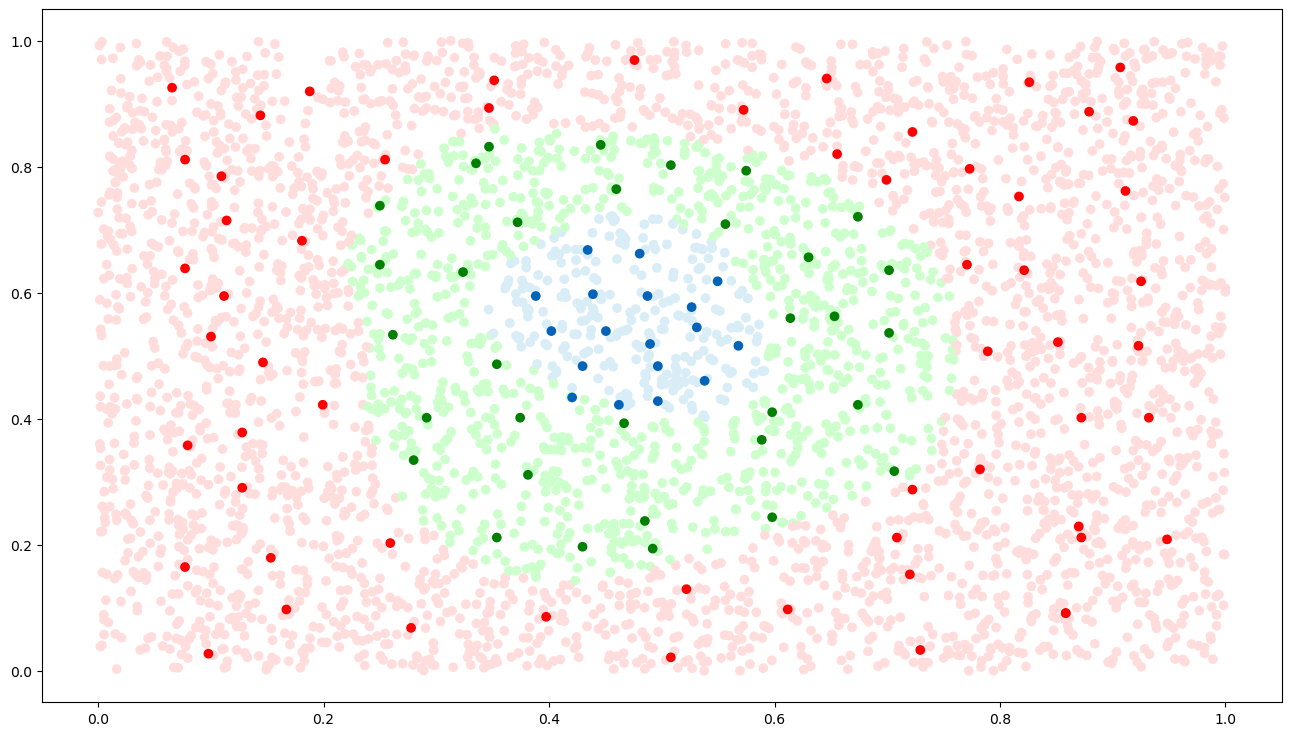

In [7]:
coordinates, classes = trainer.data_loader.return_full_data()
classes = np.array(classes, dtype = np.int64)
random_coordinates, inference_classes = trainer.inference_random_sample(4096)
inference_classes = np.array(inference_classes, dtype = np.int64)

color_map = np.array(["#ff0000", "#008000", "#0263b8"])
light_color_map = np.array(["#ffdddd", "#ccffcc", "#d9edf7"])

plt.figure(figsize = (16, 9))
plt.scatter(random_coordinates[:, 0], random_coordinates[:, 1], c = light_color_map[inference_classes])
plt.scatter(coordinates[:, 0], coordinates[:, 1], c = color_map[classes])